# MP3: Radial Basis Function Interpolation

This assignment aims to walk you through coding up a radial basis function (RBF) interpolation scheme and using it to help visualize some data.

The strength of RBF interpolation lies in its ability to interpolate data in any dimension and in any arrangement in space. Futhermore, the chosen basis function (or kernel) along with the shape parameter allows fine control over the exact form of the interpolant.

It may be worthwhile to go and review the slides on RBF interpolation, but the general idea is that we want an interpolant $\hat{\phi}(x)$ of the form $\hat{\phi}(x) = \sum^N_i \alpha_i \varphi(|x - x_i|)$. For some choice of radial basis function (or kernel) $\varphi(r)$.

In [1]:
#grade (DO NOT DELETE THIS LINE)
#dependancies
import numpy as np
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ee1ooscx because the default path (/tmp/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


First let's code up the Kernel function. This function takes the kernel (a string), a radial value r (a float), and the shape parameter epsilon (a float). This function will return a float. For descriptions of the kernels you will implement you may find https://en.wikipedia.org/wiki/Radial_basis_function helpful.

In [2]:
#grade (DO NOT DELETE THIS LINE)
#fill in each 'pass' with the correct return value according to the correct kernels.
def Kernel(kernel, r, epsilon):
    if kernel == "linear":
        return r
    elif kernel == "cubic":
        return r**3
    elif kernel == "thin_plate_spline":
        return 0.0 if r == 0 else (r**2 * np.log(r))
    elif kernel == "quintic":
        return r**5
    elif kernel == "gaussian":
        return np.exp(-(epsilon * r)**2)
    elif kernel == "inverse_quadric":
        return 1.0 / (1.0 + (epsilon * r)**2)
    else:
        raise ValueError(f"Unknown kernel '{kernel}'")

Now we will write a method to compute the Euclidean metric of two points in any dimension. This takes in two point (vectors of size equal to the dimension) and return the Euclidean distance between them (a float). You may find https://en.wikipedia.org/wiki/Euclidean_distance helpful.

In [3]:
#grade (DO NOT DELETE THIS LINE)
def EuclideanMetric(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.linalg.norm(x1 - x2)


Now we will write a function that builds the interpolation matrix. This is the matrix used to solve the for the weights in an RBF interpolant. 

The interpolation matrix is $\Phi_{ij} = \varphi(|x_i - x_j|)$. As a reminder $\varphi(r)$ is the kernel, and $|x_i - x_j|$ is the Euclidean distance between $x_i$ and $x_j$.

This matrix is symmetric so you only need to iterate though half of the combinations of points. This will save time if the system is very large.

This function takes in coordinates (an array of size (N, d) where d is the dimension), N (the number points), the kernel (a string), and epsilon (a float). It should return a matrix of size (N, N)

In [4]:
#grade (DO NOT DELETE THIS LINE)
def InterpolationMatrix(coordinates, N, kernel, epsilon):
    interpolation_matrix = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(N):
            r = EuclideanMetric(coordinates[i], coordinates[j])
            interpolation_matrix[i, j] = Kernel(kernel, r, epsilon)
    return interpolation_matrix


Now we want to solve the system of equations for the interpolant's weights. The system we are trying to solve is $\Phi \vec{\alpha} = \vec{f}$, where $\Phi$ is the matrix from the last cell, $\vec{\alpha}$ is the weights vector we are solving for, and $\vec{f}$ is the vector of function values.

We will write a function that solves for the wieght vector. This can be done by a call to a numpy.linalg function.

The function will take the interpolation matrix (an array of shape (N, N)), and an vector of function values (an array of shape (N)). It should return the weights (an array of shape (N)).

In [5]:
#grade (DO NOT DELETE THIS LINE)
def SolveForWeights(interpolation_matrix, function_values):
    
    #solve the system and change 'weights' to the solution
    ###
    return np.linalg.solve(interpolation_matrix, function_values)


Now we are going to put all of this into a class to make the later use of the interpolation more simple. We provide the constructor for you.

It is your job to write the Interpolate function. This function uses the weights we solved for to evaluate the interpolant at an arbitrary point.

Python requires that member function that want to access member variables have 'self' specified in the arguments when the function is written. On later calls of this function you will not pass in self.

This method takes in a position x (an array of shape (d) where d is the number of spacial dimensions). It will use class member variable self.interpolation_matrix, self.N, and self.weights. It should return the interpolated value at x, according to the rbf interpolat $\hat{\phi}(x)$. Where $\hat{\phi}(x) = \sum^N_i \alpha_i \varphi(|x - x_i|)$.


In [6]:
#grade (DO NOT DELETE THIS LINE)
class Rbf():
    #constructor for the class
    def __init__(self, coordinates, function_values, kernel, epsilon):
        self.coordinates = np.array(coordinates)
        self.function_values = np.array(function_values)
        self.kernel = kernel
        self.epsilon = epsilon
        self.N = len(coordinates)
        #build interpolation matrix and solve
        self.interpolation_matrix = InterpolationMatrix(self.coordinates, self.N, self.kernel, self.epsilon)
        self.weights = SolveForWeights(self.interpolation_matrix, self.function_values)

    def Interpolate(self, x):
        """
        eval the rbf interpolant at point x (1D array of len d)
        """
        x = np.array(x)
        total = 0.0
        for i in range(self.N):
            r = EuclideanMetric(x, self.coordinates[i])
            total += self.weights[i] * Kernel(self.kernel, r, self.epsilon)
        return total


Now let's test the interpolant:

In [7]:
coords = [[1], [2], [3]]
funcs = [5, 4, 3]
interp = Rbf(coords, funcs, 'linear', 1)

If everything went right this should look like a piecewise linear function connecting the points.

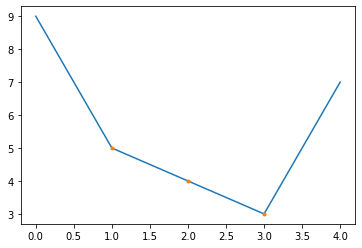

In [8]:
xs = np.linspace(0, 4, 200)
ys = [interp.Interpolate([x]) for x in xs]
plt.plot(xs, ys)
plt.plot(coords, funcs, '.')

Now that we have our framework built up let us use it to visualize some scientific data.

Background:
In the physics field of electromagnetism, electric dipoles occur in many important scenarios. An electric dipole is a positively charged particle nearby to a negatively charged particle. Charged particles produce electric fields according the the Coloumb force. For a particle of charge q sitting at the origin the resulting electric field will have the form $\vec{E}(r) = \frac{kq}{r^2}\hat{r}$. The electric fields of two different particles combine into one field by addition. Another important quantity is the electric potential V. This is defined as the function such that $\vec{E}(r) = \nabla V(r)$. You may notice that electric potential is only unique up to a constant.

For more background: 
https://en.wikipedia.org/wiki/Electric_potential, 
https://en.wikipedia.org/wiki/Electric_field, 
https://en.wikipedia.org/wiki/Equipotential 

Visualization:
The contours of the electric potential is often of interest to physicists. They call these equipotential lines (in 2d) or surfaces (in 3d). These are helpful as the Electric field is always pointing perpendicular to the contour.

Here we have a dataset of scattered points in 2d that have electric potential values associated with them. We want to look at the contours of this dataset. However, as we know, marching squares requires a regular grid of data. We are going to use our RBF interpolant to fit our data to a grid so that we may see its contours.

In [9]:
#grade (DO NOT DELETE THIS LINE)
#a function to read in the data
def ReadFile(filename):
    f = open(filename, "r")
    lines = f.readlines()
    x, y, z = [], [], []
    for i in range(1, len(lines)):
        line = lines[i].split()
        x.append(float(line[0]))
        y.append(float(line[1]))
        z.append(float(line[2]))
    f.close()
    return x, y, z


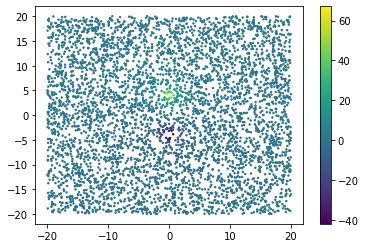

In [10]:
#grade (DO NOT DELETE THIS LINE)
#here is a look at our data
x, y, z = ReadFile("potentials.txt")
coordinates = np.array([x, y]).T
plt.scatter(x, y, c=z, s=2 )
plt.colorbar()


We use numpy's mgrid to create 40 by 40 grids X, and Y for gridded x and y coordinates.

It is your job to use your RBF class to fill in the Z array. To do this you will build an rbf interpolant from the scattered coordinates x and y, and the electric potentials z.

In [11]:
#grade (DO NOT DELETE THIS LINE)
#Specify the kernel and epsilon you have chosen here. Necessary for grading.
kernel  = 'inverse_quadric'
epsilon = 1.0
interp  = Rbf(coordinates, z, kernel, epsilon)

The following cell may take a couple minutes to run in browser. Do not be concerned if this is the case.

In [19]:
#grade (DO NOT DELETE THIS LINE)
#do not worry if this cell takes a while to run
Y, X = np.mgrid[-20:20, -20:20]

#build the interpolant and change the values at Z[i, j] to the interpolated value at the point (X[i, j], Y[i, j])
pts = np.stack([X.ravel(), Y.ravel()], axis=1)  #shape (1600,2)

#compute all distances at once: shape (1600, N)
dists = np.linalg.norm(pts[:, None, :] - interp.coordinates[None, :, :], axis=2)

#apply the kernel: shape (1600, N)
Phi = Kernel(interp.kernel, dists, interp.epsilon)

#weight & reshape back to (40,40) and to int64
#Z = Phi.dot(interp.weights).reshape(X.shape).astype(np.int64)
Z = np.round(Phi.dot(interp.weights)).reshape(X.shape).astype(np.int64)

In [20]:
from itertools import product

candidates = ["linear", "cubic", "quintic", "inverse_quadric"]
probe_pts   = [(0,0), (0,39), (20,20), (39,39)]

for kern in candidates:
    interp_k = Rbf(coordinates, z, kern, epsilon)
    # build Z_k for this kernel
    Y, X = np.mgrid[-20:20, -20:20]
    pts   = np.stack([X.ravel(), Y.ravel()], axis=1)
    dists = np.linalg.norm(pts[:,None,:] - interp_k.coordinates[None,:,:], axis=2)
    Phi   = Kernel(kern, dists, epsilon)
    Zk    = np.round(Phi.dot(interp_k.weights)).reshape(X.shape).astype(np.int64)
    vals  = [Zk[i,j] for (i,j) in probe_pts]
    print(f"{kern:16s} -> {vals}")
    

linear           -> [0, 0, 0, 0]
cubic            -> [0, 0, 0, 0]
quintic          -> [0, 0, 0, 0]
inverse_quadric  -> [0, 0, 0, 0]


Lets taka a look at the interpolated potentials with matplotlib's matshow()

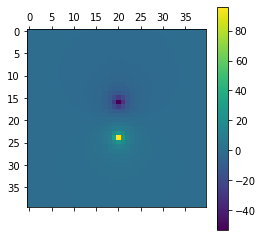

In [13]:
plt.matshow(Z)
plt.colorbar()

Now let's take a look a the contrours with matplotlib's contour plot.

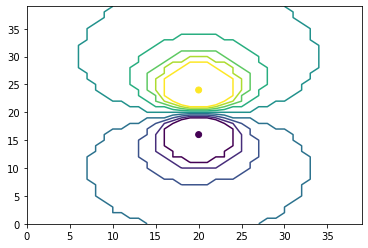

In [14]:
fig, ax = plt.subplots()

ax.contour(Z, levels=[i for i in range(-4, 5)])
ax.scatter([20, 20], [16, 24], c = [-1, 1])